In [1]:
import os
import pickle
from time import time
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
import torch.utils.data as torch_data

In [3]:
from model import UnetGenerator, Discriminator
from utils import *
from train import Pix2PixModel

In [4]:
# Only to fix the Mac's problem
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [5]:
acceleration = 2

PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_single_source_val'
PATH_TO_SAMPLED_TRAIN = f'data/ax_t2_single_sampled_x{acceleration}_train'
PATH_TO_SAMPLED_VAL = f'data/ax_t2_single_sampled_x{acceleration}_val'

PATH_TO_RESULTS = 'results'

RANDOM_STATE = 42

In [6]:
os.makedirs(PATH_TO_RESULTS, exist_ok=True)

## Load the data

In [7]:
fmri_train = fastMRIData(PATH_TO_SOURCE_TRAIN, PATH_TO_SAMPLED_TRAIN)
fmri_val = fastMRIData(PATH_TO_SOURCE_VAL, PATH_TO_SAMPLED_VAL)

len(fmri_train), len(fmri_val)

(47024, 11756)

In [8]:
fmri_train.images = fmri_train.images[:2]
fmri_val.images = fmri_val.images[:2]

len(fmri_train), len(fmri_val)

(2, 2)

	MAE	PSNR	SSIM
score	0.060	21.064	0.585


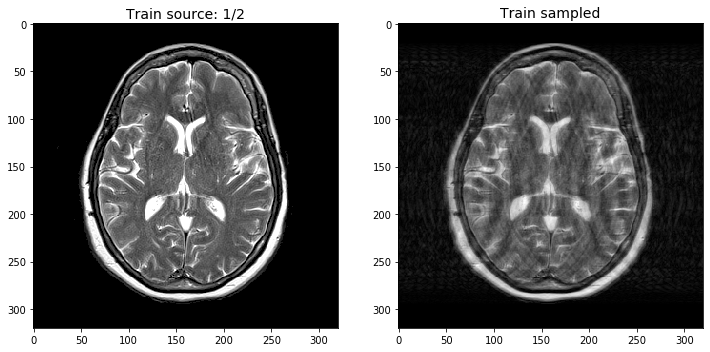

	MAE	PSNR	SSIM
score	0.054	21.759	0.673


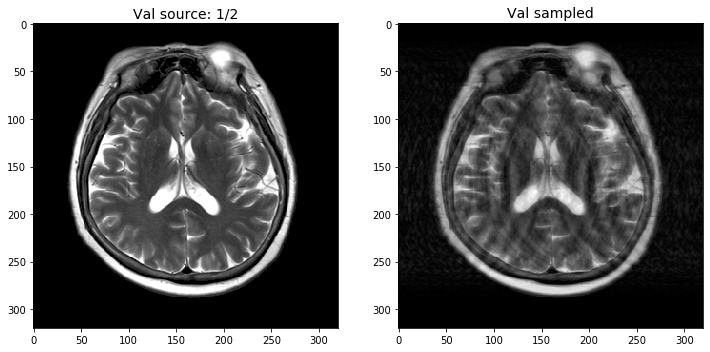

In [9]:
for fmri, type_ in zip([fmri_train, fmri_val], ['Train', 'Val']):

    i = np.random.randint(0, len(fmri))
    source, sampled = fmri.__getitem__(i)

    fig, axis = plt.subplots(1, 2, figsize=(12, 10))
    axis[0].imshow(source[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title(f'{type_} source: {i+1}/{len(fmri)}', fontsize=14)
    axis[1].imshow(sampled[0], cmap='gray', vmin=0, vmax=1)
    axis[1].set_title(f'{type_} sampled', fontsize=14)

    compare_imgs(source, sampled, verbose=True)

    plt.show()

## Training

In [11]:
torch.manual_seed(RANDOM_STATE)

G = UnetGenerator()
D = Discriminator()

l1_lambda = 100
lr = 0.0002
betas = (0.5, 0.999)

G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=betas)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=betas)

train_loader = torch_data.DataLoader(fmri_train, batch_size=32, shuffle=True, num_workers=8) 
val_loader = torch_data.DataLoader(fmri_val, batch_size=32, shuffle=False, num_workers=8) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

if device == torch.device('cuda:0'):
    torch.cuda.empty_cache()

Device: cpu


In [15]:
%%time

model_name = 'test22'
epochs = 2
logging = True 
verbose = True

pix2pix = Pix2PixModel(G, D, G_optimizer, D_optimizer, l1_lambda, acceleration, 
                      PATH_TO_RESULTS, device, model_name)

if verbose:
        print('Path to results:', pix2pix.results_dir)
        print('Device:', device)
        print('Model_name:', pix2pix.model_name)
        print()

if logging:
    write_train_params(pix2pix.log_file, device=device, random_state=RANDOM_STATE, epochs=epochs, 
                       l1_lambda=l1_lambda, G_optimizer=G_optimizer, D_optimizer=D_optimizer)

pix2pix.train(epochs, train_loader, val_loader, verbose=True, logging=logging)

Path to results: results/x2/test22
Device: cpu
Model_name: test22

Epoch 1/2 | Train loss: [Dis: 0.6713, Gen: 27.2645] | Val loss: [Dis: 0.6871, Gen: 39.7924] | 0 min 11 sec
Epoch 2/2 | Train loss: [Dis: 0.6307, Gen: 24.6478] | Val loss: [Dis: 0.6793, Gen: 38.0489] | 0 min 10 sec

Train time: 0.3 min
CPU times: user 22 s, sys: 4.47 s, total: 26.5 s
Wall time: 21 s


In [16]:
!cat $pix2pix.log_file

Train params:
	'device': cpu
	'random_state': 42
	'epochs': 2
	'l1_lambda': 100
	'G_optimizer': Adam (Parameter Group 0    amsgrad: False    betas: (0.5, 0.999)    eps: 1e-08    lr: 0.0002    weight_decay: 0)
	'D_optimizer': Adam (Parameter Group 0    amsgrad: False    betas: (0.5, 0.999)    eps: 1e-08    lr: 0.0002    weight_decay: 0)

Epoch 1/2 | Train loss: [Dis: 0.6713, Gen: 27.2645] | Val loss: [Dis: 0.6871, Gen: 39.7924] | 0 min 11 sec
Epoch 2/2 | Train loss: [Dis: 0.6307, Gen: 24.6478] | Val loss: [Dis: 0.6793, Gen: 38.0489] | 0 min 10 sec

Train time: 0.3 min


In [17]:
load_history_loss(pix2pix.losses_file)

{'Train': {'generator': [27.264501571655273, 24.647804260253906],
  'discriminator': [0.6712968349456787, 0.6307147145271301]},
 'Val': {'generator': [39.792388916015625, 38.04887771606445],
  'discriminator': [0.6871041059494019, 0.6792985200881958]}}

In [21]:
G = load_torch_model(Generator(), os.path.join(pix2pix.models_dir, 'G_best.pth'))
# G.to(device)
# D = load_torch_model(Discriminator(), os.path.join(pix2pix.models_dir, 'D_best.pth'))

Source and restored:
	MAE	PSNR	SSIM
score	0.267	9.015	0.081

Source and sampled:
	MAE	PSNR	SSIM
score	0.060	21.064	0.585


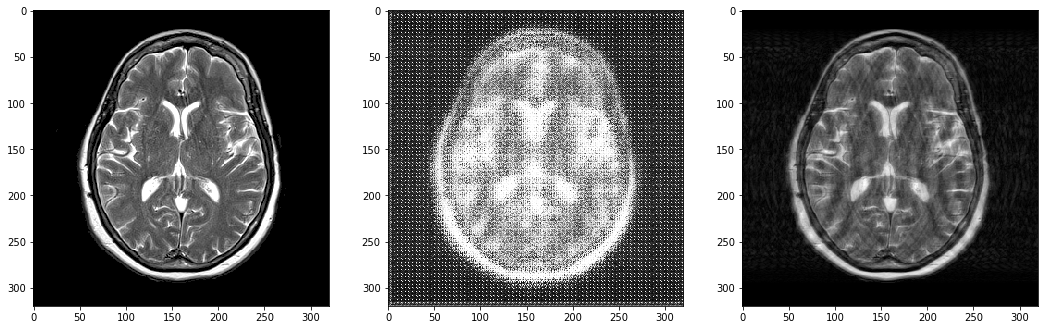

In [22]:
n = 1

for i, (source, sampled) in enumerate(train_loader, 1):

    restored = G(sampled)

    fig, axis = plt.subplots(1, 3, figsize=(18, 16))
    axis[0].imshow(source[0, 0], cmap='gray', vmin=0, vmax=1)
    axis[2].imshow(sampled[0, 0], cmap='gray', vmin=0, vmax=1)
    axis[1].imshow(restored[0, 0].data, cmap='gray', vmin=0, vmax=1)

    print('Source and restored:')
    compare_imgs(source[0, 0].data, restored[0, 0].data, verbose=True)
    print('\nSource and sampled:')
    compare_imgs(source[0, 0].data, sampled[0, 0].data, verbose=True)

    plt.show()

    if i >= n:
        break